# Introduction 

The DigitClassifierDemo notebook illustrates how the image processing process works and features a training session where four parameters (average area, average perimeter, avergage aspect ratio and average convex hull area to real area ratio) were found. These will be used in the following notebook, where I attempt to classify the images of the MNIST test training test.

In [1]:
from mlxtend.data import loadlocal_mnist
import numpy as np
import matplotlib.pyplot as plt
import cv2
import statistics 
from timeit import default_timer as timer
import random

Select the MNIST test dataset:

In [2]:
directory = '/home/erik/Documents/Image-Classification/'

X, y = loadlocal_mnist(
        images_path= directory + 't10k-images.idx3-ubyte', 
        labels_path= directory + 't10k-labels.idx1-ubyte')

numberImages = len(y)
print('There are a total of %s images in the test data set.' %(numberImages))

There are a total of 10000 images in the test data set.


If visual inspection for one of the raw images is needed, this can be done here:

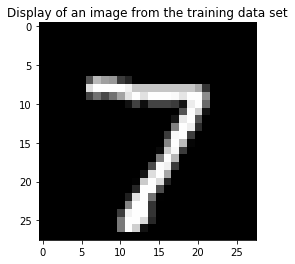

Index of image: 0, Label of image: 7


In [3]:
index = 0
myimage = X[index].reshape((28,28))
plt.imshow(myimage,'gray')
plt.title('Display of an image from the training data set')
plt.show() 
print('Index of image: %s, Label of image: %s' %(index, y[index]))

# Random classification

Before an attempt is made to classify the images from the MNIST test data set, a random classification in made. This entails that each of the images is classified using a random label from the list of possible digits.

In [4]:
ErrorCount = 0
resizing = 5
numberSamples = numberImages

startTime = timer()

for index in range(0, numberSamples):
    Guess = random.randint(0,9)
    ActualLabel = y[index]
    if ActualLabel != Guess:
        ErrorCount += 1

endTime = timer()
    
accuracy = (numberSamples-ErrorCount)/ numberSamples
print('Number of samples: %s, Number of errors: %s, Accuracy: %s' %(numberSamples, ErrorCount, accuracy))

print('Time it took for classification: %.2f seconds' %(endTime - startTime))

Number of samples: 10000, Number of errors: 9005, Accuracy: 0.0995
Time it took for classification: 0.06 seconds


For classification of all the images in the data set (10000 samples), the random classifier made 9005 errors, meaning it has an accuracy of about 10%.

# Traditional classification

Classification Using the numberSamples variable the user can specify how many of the images from the test dataset they want to classify.

The four perimeters which will be used during the classification of some of the digits:

In [5]:
# Retrieved from the Demo:

Digits = [2,3,4,5,7]
Areas = [3787.8, 3874.4, 3324.0, 3465.5, 3220.3]
Perimeters = [450.8, 501.2, 435.5, 471.8, 411.8]
AspectRatios = [1.0413, 1.1720, 1.2360, 1.1121, 1.2691]
ConvexHullRatios = [0.5960, 0.5882, 0.6052, 0.6030, 0.5977]

In [6]:
ErrorCount = 0
resizing = 5
numberSamples = numberImages

startTime = timer()

for index in range(0, numberSamples):
    # Gathering info abou the image:
    Image0 = X[index]
    Image = cv2.resize(Image0.reshape((28,28)),None, fx = resizing, fy = resizing, interpolation = cv2.INTER_LINEAR)
    maxycoord = resizing * 28
    tvalue = statistics.mean(Image0)
    maxvalue = max(Image0)
    ret,BinIm = cv2.threshold(Image,tvalue,maxvalue,cv2.THRESH_BINARY)
    edged=cv2.Canny(BinIm, 10, 200)
    (contours, _)=cv2.findContours(BinIm,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
    
    # Ensuring that a contour is not being build around a spot of noise:
    if len(contours) > 1 and cv2.contourArea(contours[0]) < cv2.contourArea(contours[1]):
        contours = contours[1:]
    
    if len(contours) > 2:
        # Only for digit 8
        Guess = 8
        
    elif len(contours) == 2:
        # For digits 0, 6 and 9
        innerArea = cv2.contourArea(contours[0])
        totalArea = cv2.contourArea(contours[1])
        realArea = totalArea - innerArea
        if innerArea/realArea > 0.25:
            # Only for digit 0
            Guess = 0
        else:
            moments = cv2.moments(contours[0])
            ycentroid = moments['m01']/moments['m00']
            maxycoord = resizing * 28
            if ycentroid/maxycoord < 0.5:
                # Only for digit 9
                Guess = 9
            else:
                # Only for digit 6
                Guess = 6
    else:
        # For digits 1, 2, 3, 4, 5, 7
        (startingx, startingy, width, height) = cv2.boundingRect(contours[0])
        aspect_ratio = height / width
        if aspect_ratio > 2.5:
            # Only for digit 1
            Guess = 1
        else:
            # For digits 2, 3, 4, 5, 7
            DigitArea = cv2.contourArea(contours[0])
            DigitPerimeter = cv2.arcLength(contours[0], True)
            (startingx, startingy, width, height) = cv2.boundingRect(contours[0])
            DigitAspectRatio = height / width
            hull = cv2.convexHull(contours[0])
            hullArea = cv2.contourArea(hull)
            DigitConvexHullRatio = DigitArea/hullArea
            
            scores = len(Digits) * [None]
            for currentIndex in range(0, len(Digits)):
                error_area = ((Areas[currentIndex] - DigitArea)/Areas[currentIndex])**2
                error_per = ((Perimeters[currentIndex] - DigitPerimeter)/Perimeters[currentIndex])**2
                error_aspect = ((AspectRatios[currentIndex] - DigitAspectRatio)/AspectRatios[currentIndex])**2
                error_aspect = ((ConvexHullRatios[currentIndex] - DigitConvexHullRatio)/ConvexHullRatios[currentIndex])**2
                scores[currentIndex] = error_area+error_per+error_aspect
                       
            Guess = Digits[scores.index(min(scores))] 
            
    ActualLabel = y[index]
    if ActualLabel != Guess:
        ErrorCount += 1
    #print('Index: %3s, Actual label: %s, Guess: %s' %(index, ActualLabel, Guess))

endTime = timer()
    
accuracy = (numberSamples-ErrorCount)/ numberSamples
print('Number of samples: %s, Number of errors: %s, Accuracy: %s' %(numberSamples, ErrorCount, accuracy))

print('Time it took for classification: %.2f seconds' %(endTime - startTime))

Number of samples: 10000, Number of errors: 7182, Accuracy: 0.2818
Time it took for classification: 12.47 seconds


For classification of all the images in the data set (10000 samples), the traditional classifier made 7182 errors, meaning it has an accuracy of about 28%.